In [1]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import seaborn as sn

plt.style.use("ggplot")

# Elveovervåkingsprogrammet - average monthly temperatures

This notebook calculates average monthly temperatures for the 20 main rivers in the 2019-20 monitoring programme. Data come from a variety of sources, so the workflow is a bit messy. See e-mail from Liv Bente received 28.08.2020 at 13:43 for more details. 

**Note:** The most recent temperature data is Hydra-II is located in a slightly different place to the usual discharge series. To get to the temperature data, first start the **DAGUT** program (as usual) and click **Hent** to open the station selector window. At the top of this window, open the drop-down list and choose **HYKVAL** (second item down) then search for the station of interest. Temperature series have variable code 1003 in the database.

## 1. Get manual data from RESA2

The code below gets all the temperature data from RESA2 and calculates monthly averages.

In [2]:
# Connect to db
eng = nivapy.da.connect()

Username:  ···
Password:  ········


Connection successful.


In [3]:
# Year of interest
year = 2019

In [4]:
# Find project
prj_df = nivapy.da.select_resa_projects(eng)
prj_df = prj_df.query("project_name.str.contains('lveovervåking')", engine="python")
prj_df

590 projects in the RESA database.


,project_id,project_number,project_name,contact_person,project_description
571,4230,O 16384,Elveovervåkingsprogrammet,None,Videreføring av RID. Tilførsler fra elver til ...


In [5]:
# Get stations
stn_df = nivapy.da.select_resa_project_stations(prj_df, eng)
stn_df

,station_id,station_code,station_name,latitude,longitude,altitude
0,29612,BUSEDRA,Drammenselva,NaN,NaN,None
1,29615,VESENUM,Numedalslågen,NaN,NaN,None
2,29613,TELESKI,Skienselva,NaN,NaN,None
3,30019,AAGEVEG,Vegårdselva,58.669996,8.980983,None
4,29614,VAGEOTR,Otra,NaN,NaN,None
5,29832,ROGEBJE,Bjerkreimselva,NaN,NaN,None
6,29783,ROGEORR,Orreelva,NaN,NaN,None
7,29617,ØSTEGLO,Glomma ved Sarpsfoss,59.279802,11.134111,None
8,36225,OSLEALN,Alna,59.905091,10.791359,None
9,29837,ROGEVIK,Vikedalselva,NaN,NaN,None


In [6]:
# Not interested in TROEMÅL (it has now been replaced by TROEMÅL2)
#stn_df = stn_df.query("station_id != 29848")

In [7]:
# Find ID for temp var
par_grid = nivapy.da.select_resa_station_parameters(
    stn_df, f"{year}-01-01", f"{year}-12-31", eng
)
par_grid.query('parameter_name == "Temp"')

31 parameters available for the selected stations and dates.


,parameter_id,parameter_name,unit
27,125,Temp,oC


In [8]:
# Get temp data
wc_df, dup_df = nivapy.da.select_resa_water_chemistry(
    stn_df,
    [
        125,
    ],
    f"{year}-01-01",
    f"{year}-12-31",
    eng,
)

wc_df.head()

,station_id,station_code,station_name,sample_date,depth1,depth2,Temp_oC
,,,,,,,
0,29612,BUSEDRA,Drammenselva,2019-01-07 12:35:00,0,0,1.4
1,29612,BUSEDRA,Drammenselva,2019-02-04 12:00:00,0,0,0.0
2,29612,BUSEDRA,Drammenselva,2019-03-04 11:30:00,0,0,1.5
3,29612,BUSEDRA,Drammenselva,2019-04-02 13:00:00,0,0,2.7
4,29612,BUSEDRA,Drammenselva,2019-05-06 10:30:00,0,0,5.5


In [9]:
# Print number of measurements in year for each site
print(wc_df[["station_id", "Temp_oC"]].groupby("station_id").count())

# Aggregate to monthly
wc_df["month"] = wc_df["sample_date"].dt.month
agg = wc_df[["station_id", "month", "Temp_oC"]].groupby(["station_id", "month"])
mon_df = agg.mean().reset_index()

            Temp_oC
station_id         
29612            16
29613             3
29615             2
29617            16
29778             1
29819            12
29820            12
29821             1
29822            12
29832            10
29842            12
29844            12
36225            12
38005            12


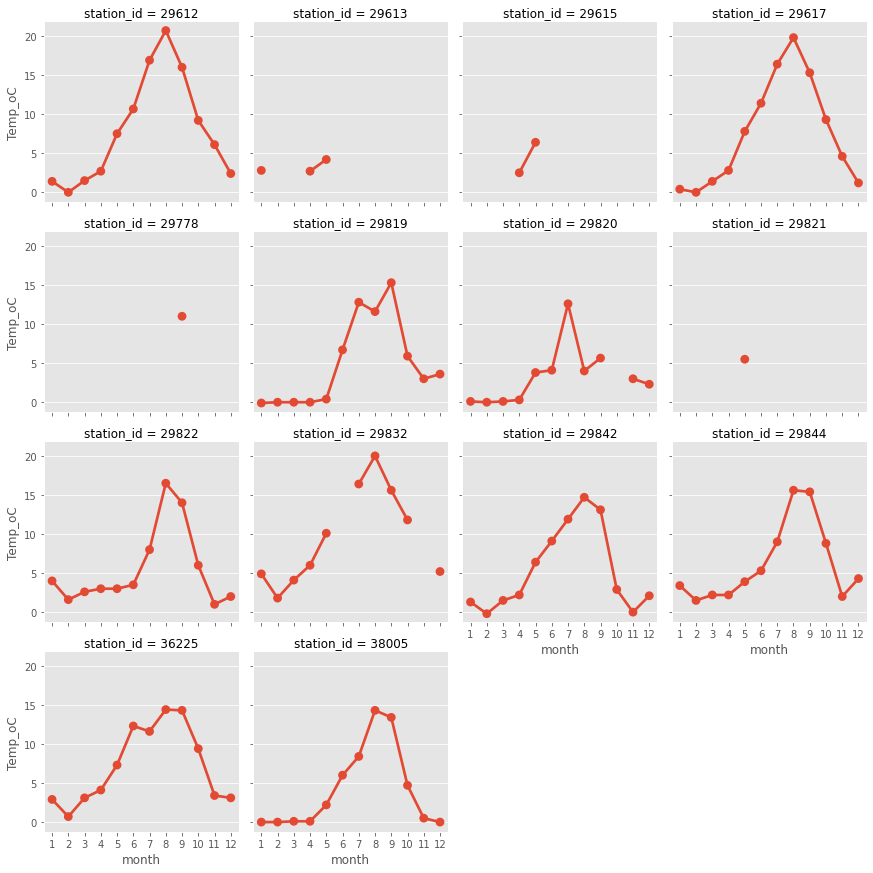

In [10]:
# Plot monthly means
sn.catplot(
    x="month",
    y="Temp_oC",
    data=mon_df,
    col="station_id",
    col_wrap=4,
    kind="point",
    height=3,
)

# Save
out_path = f"../../../Data/temperature_data/temp_{year}-{year - 1999}/other/temps_manual_{year}.png"
plt.savefig(out_path, dpi=300)

In [11]:
# Pivot to "wide" format
man_df = mon_df.pivot(index="station_id", columns="month", values="Temp_oC")

man_df

month,1,2,3,4,5,6,7,8,9,10,11,12
station_id,,,,,,,,,,,,
29612,1.4,0.0,1.5,2.7,7.5,10.666667,16.9,20.7,16.00,9.2,6.1,2.4
29613,2.8,NaN,NaN,2.7,4.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29615,NaN,NaN,NaN,2.5,6.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29617,0.4,0.0,1.4,2.8,7.8,11.400000,16.4,19.8,15.30,9.3,4.6,1.2
29778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.00,NaN,NaN,NaN
29819,-0.1,0.0,0.0,0.0,0.4,6.700000,12.8,11.6,15.30,5.9,3.0,3.6
29820,0.1,0.0,0.1,0.3,3.8,4.100000,12.6,4.0,5.65,NaN,3.0,2.3
29821,NaN,NaN,NaN,NaN,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29822,4.0,1.6,2.6,3.0,3.0,3.500000,8.0,16.5,14.00,6.0,1.0,2.0


Based on Liv Bente's spreadsheet here

    K:\Prosjekter\Ferskvann\16384 Elveovervåkingsprogrammet\2019\4. Data\6. Vanntemperatur\Grunnprogrammet\2018_TempData_Overview_oppdat for 2019_28aug20.xlsx
    
we will use the data from RESA for 9 stations. Filter to just these.

In [12]:
# Filter to desired stations for RESA
resa_list = [29617, 36225, 29612, 29832, 29842, 29822, 29844, 29820, 29819]
man_df = man_df.query("station_id in @resa_list")

## 2. TinyTag data

TinyTags are deployed in 7 rivers and the sensors are swapped in the middle of the year, so we need to splice together two data files for each location. The TinyTags are often recording even when they're out of the water, so it's important to know the date when each logger was taken in/set out. See Liv Bente's spreadsheet here:

    K:\Prosjekter\Ferskvann\16384 Elveovervåkingsprogrammet\2020\4. Data\6. Vanntemperatur\1. TinyTag temperatursensor\1. Oversikt inn ut setting templogger RID hoved 2014-15-16-17-18-19_lbs.xlsx
    
**Note:** The date format in the text files sometimes changes (e.g from `%d.%m.%Y %H.%M.%S,%f` to `%d.%m.%Y %H:%M:%S,%f`), so it might be necessary to modify the code below.

**Note 2:** The logger in Orreelva was missing when field staff tried to collect it in June 2020. This means **all temperature data from June 2019 to June 2020 has been lost**. I have created a blank placeholder file, `Orreelva_2019-20.txt` so the code below will run OK.

#### Added 02.09.2020

Tiny tag data for Vefsna and Altaelva are not yet available. **Uncomment the lines below once Liv Bente has the files**.

In [13]:
# Dates from Liv Bente's spreadsheet for 2018
swap_dates = {
    29615: ["Numedalslagen", "2019-06-03 09:30"],
    29613: ["Skienselva", "2019-06-03 10:00"],
    29614: ["Otra", "2019-06-03 12:50"],
    29783: ["Orreelva", "2019-06-03 09:00"],
    29821: ["Vosso", "2019-06-03 13:00"],
    29782: ["Vefsna", "2019-07-31 09:35"],
    29779: ["Altaelva", "2019-08-06 09:25"],
}

# Base folder (with tidied file names)
data_fold = r"../../../Data/temperature_data"

Numedalslagen
Skienselva
Otra
Orreelva
Vosso
Vefsna
Altaelva


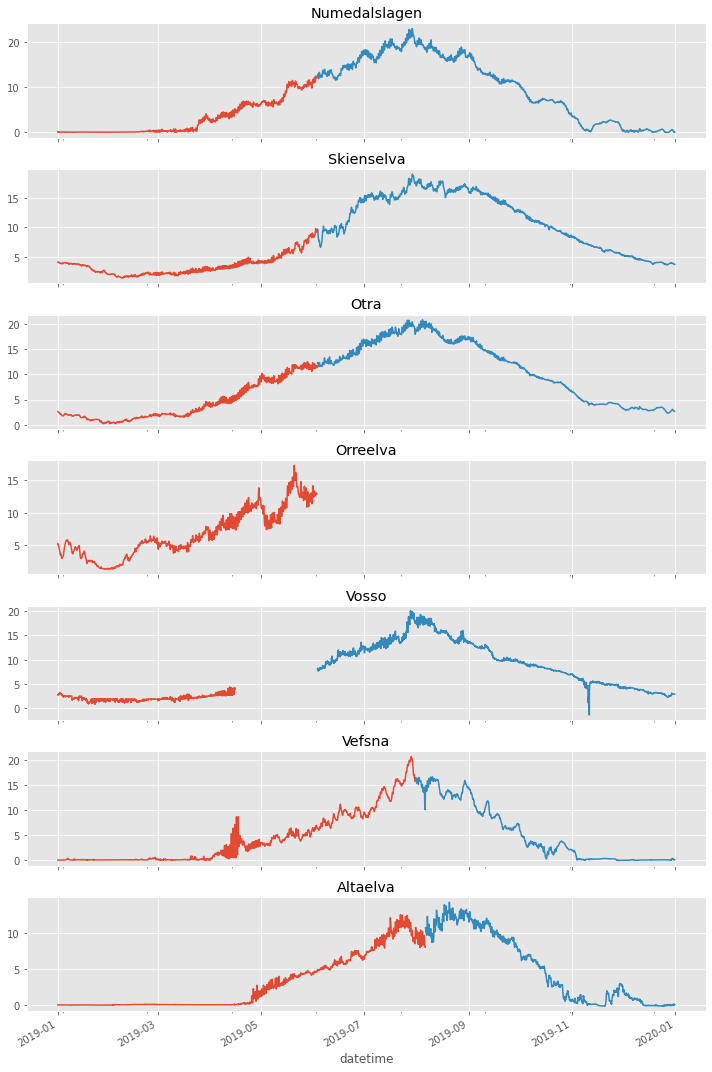

In [14]:
# Container for output
df_list = []

# Setup plot
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(10, 15), sharex=True)

# Loop over stations
for idx, stn_id in enumerate(swap_dates.keys()):
    # Get stn
    stn = swap_dates[stn_id][0]
    print(stn)

    # Get data paths
    path_prev_yr = os.path.join(
        data_fold,
        f"temp_{year - 1}-{year - 2000}/tiny_tag/{stn}_{year - 1}-{year - 2000}.txt",
    )
    path_yr = os.path.join(
        data_fold, f"temp_{year}-{year - 1999}/tiny_tag/{stn}_{year}-{year - 1999}.txt"
    )

    # Parse series 1
    df_prev_yr = pd.read_csv(
        path_prev_yr,
        delim_whitespace=True,
        skiprows=2,
        names=["date", "time", "temp"],
        decimal=",",
    )
    df_prev_yr["datetime"] = df_prev_yr["date"] + " " + df_prev_yr["time"]
    df_prev_yr["datetime"] = pd.to_datetime(
        df_prev_yr["datetime"], format="%d.%m.%Y %H:%M:%S,%f"
    )
    df_prev_yr.set_index("datetime", inplace=True)
    del df_prev_yr["date"], df_prev_yr["time"]

    # Parse series 2
    df_yr = pd.read_csv(
        path_yr,
        delim_whitespace=True,
        skiprows=2,
        names=["date", "time", "temp"],
        decimal=",",
    )
    df_yr["datetime"] = df_yr["date"] + " " + df_yr["time"]
    df_yr["datetime"] = pd.to_datetime(df_yr["datetime"], format="%d.%m.%Y %H:%M:%S,%f")
    df_yr.set_index("datetime", inplace=True)
    del df_yr["date"], df_yr["time"]

    # Get date logger changed
    swap_dt = pd.to_datetime(swap_dates[stn_id][1])
    swap_dt_plus1 = swap_dt + pd.DateOffset(
        hours=3
    )  # Skip 3 hrs to allow time for re-equilibration

    # Truncate series 1
    df_prev_yr = df_prev_yr.truncate(before="%s-01-01 00:00" % year, after=swap_dt)

    # Truncate series 2
    df_yr = df_yr.truncate(before=swap_dt_plus1, after="%s-12-31 23:59" % year)

    # Combine
    df = pd.merge(df_prev_yr, df_yr, how="outer", left_index=True, right_index=True)

    # Plot
    df.plot(ax=axes[idx], legend=False)
    axes[idx].set_title(stn)

    # Concat to single series
    df = pd.concat([df_prev_yr, df_yr], axis=0, sort=True)

    # Monthly avgs.
    df = df.resample("M").mean()

    # Add to output
    df["station_id"] = stn_id
    df_list.append(df)

plt.tight_layout()

In [15]:
# Combine results
df = pd.concat(df_list, axis=0, sort=True)
df.columns = ["station_id", "Temp_oC"]
df["month"] = df.index.month
df.reset_index(inplace=True)
tt_df = df.pivot(index="station_id", columns="month", values="Temp_oC")
tt_df

month,1,2,3,4,5,6,7,8,9,10,11,12
station_id,,,,,,,,,,,,
29613,3.258535,1.856205,2.362651,3.570194,5.847003,10.519456,15.716169,16.761815,14.791028,10.381960,6.689556,4.354032
29614,1.396022,1.174851,2.417174,5.873236,10.224274,13.149246,18.042487,17.941573,14.104347,9.117114,4.520875,3.086062
29615,0.035632,0.100610,0.908654,4.701944,8.621882,13.786736,18.764879,17.762702,12.714222,7.002550,1.870875,0.310161
29779,0.033441,0.080565,0.074361,0.335042,3.418468,5.828097,9.520202,11.262588,10.054875,4.262591,0.759639,0.398602
29782,0.025255,0.081027,0.088479,2.269000,4.518992,8.393556,13.922308,14.303065,8.897097,2.841651,0.285083,0.003575
29783,3.204852,3.864643,5.389798,9.162819,11.469234,12.848421,NaN,NaN,NaN,NaN,NaN,NaN
29821,2.049449,1.742381,2.113849,3.020085,NaN,10.429695,14.249059,15.822124,11.219889,8.247503,5.165597,3.460255


## 3. Other logger data

Other temperature data is also available for Målselv and Vegårdselva (= Storelva/Lundevann)

### 3.1. Målselva

In [16]:
# Read raw data
in_xlsx = f"../../../Data/temperature_data/temp_{year}-{year - 1999}/other/malselva_{year}.xlsx"
df = pd.read_excel(in_xlsx, sheet_name="Temp")
del df["StationName"]
df['Date'] = pd.to_datetime(df['Date'], format="%d.%m.%Y %H:%M:%S")
df.set_index("Date", inplace=True)

# Resample
df = df.resample("M").mean()

# Tidy
df.columns = ["Temp_oC"]
df["month"] = df.index.month
df.reset_index(inplace=True)
del df["Date"]
df["station_id"] = 29848

mal_df = df.pivot(index="station_id", columns="month", values="Temp_oC")

mal_df

month,1,2,3,4,5,6,7,8,9,10,11,12
station_id,,,,,,,,,,,,
29848,0.028382,0.024129,0.016637,0.054518,4.389161,7.512881,11.930714,13.059973,8.465613,1.669485,0.057922,0.065601


### 3.2. Vegårdselva

In [17]:
# Read raw data
in_xlsx = f"../../../Data/temperature_data/temp_{year}-{year - 1999}/other/vegardselva_{year}.xlsx"
df = pd.read_excel(in_xlsx, sheet_name="Temp")
del df["StationName"]
df['Date'] = pd.to_datetime(df['Date'], format="%d.%m.%Y %H:%M:%S")
df.set_index("Date", inplace=True)

# Resample
df = df.resample("M").mean()

# Tidy
df.columns = ["Temp_oC"]
df["month"] = df.index.month
df.reset_index(inplace=True)
del df["Date"]
df["station_id"] = 30019

veg_df = df.pivot(index="station_id", columns="month", values="Temp_oC")

veg_df

month,1,2,3,4,5,6,7,8,9,10,11,12
station_id,,,,,,,,,,,,
30019,2.438616,2.449687,3.275195,7.393458,13.826841,17.407194,21.652423,20.86294,14.752167,9.723306,5.722431,3.817792


## 4. NVE data

For 2019, NVE datasets are only required for Vikedalselva and Orkla. Note that in previous years we have used more NVE datasets. These are commented out below, but might be relevant again in future.

In [18]:
# Dict mapping NVE temp codes to RESA IDs
stn_id_dict = {
    #'2_1087':29617,
    #'12_298':29612,
    #'15_115':29615,
    #'16_207':29613,
    #'21_79':29614,
    #'27_29':29832,
    "38_2": 29837,
    #'62_30':29821,
    #'84_23':29842,
    "121_62": 29778,
    #'151_32':29782,
    #'246_11':29819,
}

# Data folder
data_fold = f"../../../Data/temperature_data/temp_{year}-{year - 1999}/hydra-ii"

# List for data
df_list = []

# Loop over sites
for stn_cd in stn_id_dict.keys():
    # Read data
    file_path = os.path.join(data_fold, "%s.txt" % stn_cd)
    df = pd.read_csv(file_path, skiprows=2, names=["date", "Temp_oC"], na_values=-9999)
    df["date"] = pd.to_datetime(df["date"], format="%Y.%m.%d %H:%M")
    df.set_index("date", inplace=True)

    # Resample
    df = df.resample("M").mean()

    # Convert index to month
    df.index = df.index.month
    df.index.name = "month"

    # Change column to site id
    df.columns = [
        stn_id_dict[stn_cd],
    ]

    # Transpose and append
    df_list.append(df.T)

# Combine
nve_df = pd.concat(df_list, axis=0, sort=True)
nve_df.index.name = "station_id"
nve_df

month,1,2,3,4,5,6,7,8,9,10,11,12
station_id,,,,,,,,,,,,
29837,2.009903,2.189537,3.280590,6.096673,9.469694,13.00942,16.647390,16.314832,11.973187,8.352671,4.055390,3.968406
29778,0.438177,1.040064,1.189065,2.400170,5.560894,11.19757,11.468584,11.610126,8.199547,3.107319,0.891273,0.337348


## Combine

In [19]:
# Melt all and combine
# RESA
man_df2 = man_df.reset_index().melt(id_vars="station_id")
man_df2["source"] = "Manual"

# TinyTag
tt_df2 = tt_df.reset_index().melt(id_vars="station_id")
tt_df2["source"] = "TinyTag"

# Other
mal_df2 = mal_df.reset_index().melt(id_vars="station_id")
mal_df2["source"] = "Other"

veg_df2 = veg_df.reset_index().melt(id_vars="station_id")
veg_df2["source"] = "Other"

# NVE
nve_df2 = nve_df.reset_index().melt(id_vars="station_id")
nve_df2["source"] = "NVE"

# Combine
df = pd.concat([man_df2, tt_df2, mal_df2, veg_df2, nve_df2], axis=0, sort=True)

# Join stn codes
df = pd.merge(df, stn_df[["station_id", "station_code"]], how="left", on="station_id")
del df["station_id"]
df.columns = ["Month", "Source", "Temperature (C)", "Station code"]

df.head()

,Month,Source,Temperature (C),Station code
0,1,Manual,1.4,BUSEDRA
1,1,Manual,0.4,ØSTEGLO
2,1,Manual,-0.1,FINEPAS
3,1,Manual,0.1,FINETAN
4,1,Manual,4.0,MROEDRI


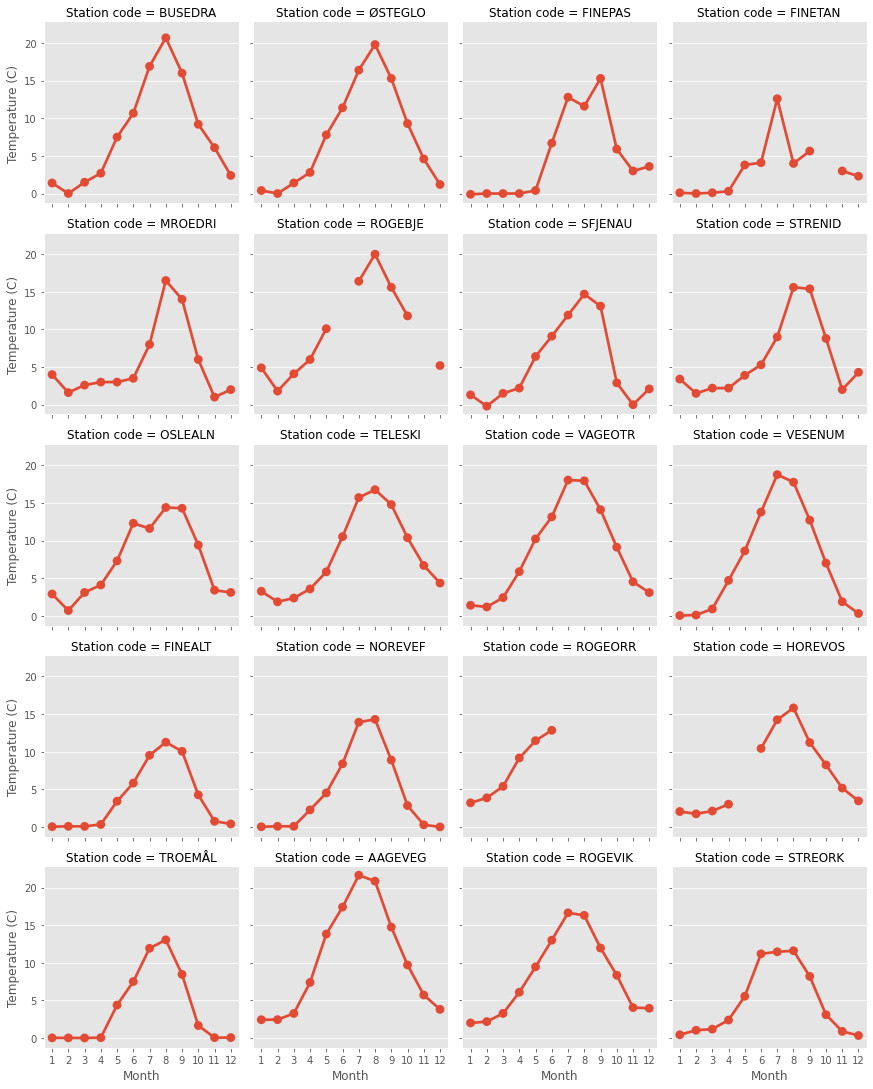

In [20]:
# Plot
sn.catplot(
    x="Month",
    y="Temperature (C)",
    data=df,
    # hue='Source',
    col="Station code",
    col_wrap=4,
    height=3,
    # linestyles=['--', '--', '--', '--'],
    kind="point",
)

# Save
out_path = f"../../../Data/temperature_data/temp_{year}-{year - 1999}/temps_all_sources_{year}.png"
plt.savefig(out_path, dpi=300)

## 5. Format for output

In [21]:
# Combine
df = pd.concat([man_df, tt_df, mal_df, veg_df, nve_df], axis=0, sort=True)
df.reset_index(inplace=True)

# Join station details
df = pd.merge(df, stn_df, how="left", on="station_id")

# Reorder
df = df[
    ["station_id", "station_code", "station_name", "latitude", "longitude", "altitude"]
    + list(range(1, 13))
]
del df["latitude"], df["longitude"], df["altitude"]

# Round values
df = df.round(2)

# Save output
out_csv = f"../../../Data/temperature_data/temp_{year}-{year - 1999}/monthly_avg_temps_{year}-{year - 1999}.csv"
df.to_csv(out_csv, encoding="utf-8", index=False)

df

,station_id,station_code,station_name,1,2,3,4,5,6,7,8,9,10,11,12
0,29612,BUSEDRA,Drammenselva,1.40,0.00,1.50,2.70,7.50,10.67,16.90,20.70,16.00,9.20,6.10,2.40
1,29617,ØSTEGLO,Glomma ved Sarpsfoss,0.40,0.00,1.40,2.80,7.80,11.40,16.40,19.80,15.30,9.30,4.60,1.20
2,29819,FINEPAS,Pasvikelva,-0.10,0.00,0.00,0.00,0.40,6.70,12.80,11.60,15.30,5.90,3.00,3.60
3,29820,FINETAN,Tanaelva,0.10,0.00,0.10,0.30,3.80,4.10,12.60,4.00,5.65,NaN,3.00,2.30
4,29822,MROEDRI,Driva,4.00,1.60,2.60,3.00,3.00,3.50,8.00,16.50,14.00,6.00,1.00,2.00
5,29832,ROGEBJE,Bjerkreimselva,4.90,1.80,4.10,6.00,10.10,NaN,16.40,20.00,15.60,11.80,NaN,5.20
6,29842,SFJENAU,Nausta,1.30,-0.20,1.50,2.20,6.40,9.10,11.90,14.70,13.10,2.90,0.00,2.10
7,29844,STRENID,Nidelva (Tr.heim),3.40,1.50,2.20,2.20,3.90,5.30,9.00,15.60,15.40,8.80,2.00,4.30
8,36225,OSLEALN,Alna,2.90,0.70,3.10,4.10,7.30,12.30,11.60,14.40,14.30,9.40,3.40,3.10
9,29613,TELESKI,Skienselva,3.26,1.86,2.36,3.57,5.85,10.52,15.72,16.76,14.79,10.38,6.69,4.35
